In [ ]:
# !pip install torch
# !pip install torchvision
# !pip install pandas
# !pip install matplotlib
# !pip install scipy
# !pip install scikit-learn

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import scipy
from torch.autograd import Variable

cudnn.benchmark = True
plt.ion()   # interactive mode

### Setting Seed

In [2]:
seed = 10
np.random.seed(seed)
torch.manual_seed(seed)

### Obtaining our datasets and dataloaders

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


train_dataset = datasets.Flowers102(root='./data/train', split = "train", transform=data_transforms["train"], download = True)
val_dataset = datasets.Flowers102(root='./data/train', split = "val", transform=data_transforms["val"], download = True)
test_dataset = datasets.Flowers102(root='./data/train', split = "test", transform=data_transforms["test"], download = True)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=4,num_workers=2 )


image_datasets = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}


dataloaders = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader,
}

dataset_sizes = {
        x: len(dataloaders[x].dataset)
        for x in list(image_datasets.keys())
    }


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

In [5]:
dataset_sizes

{'train': 1020, 'val': 1020, 'test': 6149}

### Function to visualise images

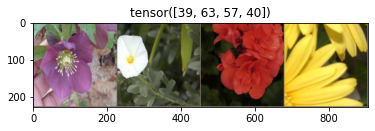

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)


imshow(out, title = classes)

### Function to test model on validation set

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # Changed classes to labels so it corresponds to the labels from dataloader['val']
                ax.set_title(f'predicted: {preds[j]} vs true: {labels[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### General function to train the model

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    checkpoint_path = './model_checkpoints'
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
 
    best_model_params_path = os.path.join(checkpoint_path, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    preds = preds.to(device)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
            print(f'{phase} Loss:\t{epoch_loss:.4f}\tAcc:\t{epoch_acc:.4f}')

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            elif phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}\n')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, train_loss, train_acc, val_loss, val_acc

### Function to plot train & val accuracy/loss

In [10]:
def plot_graph(no_epoch, train, val, title):
    plt.figure()
    plt.plot(range(no_epoch), train, label='train')
    plt.plot(range(no_epoch), val, label='val')
    if "Accuracy" in title:
        plt.ylabel("Accuracy")
    elif "Loss" in title:
        plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

### Transfer learning with freezing (transformer vit_b_16)

In [11]:
model_path = './model_checkpoints/transformer_vit_b_16_freeze_GPU.pt'

check_file = os.path.exists(model_path)
if check_file:
    print(f"Loading model from checkpoint")
    loaded_transformer = torch.load(model_path)
    
else:
    print(f"Model checkpoint does not exist.\nDownloading new model...")
    model_conv = torchvision.models.vit_b_16(weights='IMAGENET1K_V1')
    
    #freezing all other layers
    for param in model_conv.parameters():
        param.requires_grad = False
        
    num_ftrs = model_conv.heads.head.in_features
    model_conv.heads.head = nn.Linear(num_ftrs, 102)

Model checkpoint does not exist.


In [12]:
print(model_conv)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [97]:
num_epochs = 40

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.heads.head.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=50, gamma=0.1)

In [98]:
model_conv, train_loss, train_acc, val_loss, val_acc = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=num_epochs)

Epoch 0/39
----------
train Loss:	4.1959	Acc:	0.1176
val Loss:	3.3324	Acc:	0.4529

Training complete in 0m 23s
Best val Acc: 0.452941

Epoch 1/39
----------
train Loss:	2.9252	Acc:	0.5010
val Loss:	2.4573	Acc:	0.6186

Training complete in 0m 43s
Best val Acc: 0.618627

Epoch 2/39
----------
train Loss:	2.1013	Acc:	0.6961
val Loss:	1.9256	Acc:	0.7127

Training complete in 1m 2s
Best val Acc: 0.712745

Epoch 3/39
----------
train Loss:	1.6566	Acc:	0.7814
val Loss:	1.6081	Acc:	0.7696

Training complete in 1m 22s
Best val Acc: 0.769608

Epoch 4/39
----------
train Loss:	1.3302	Acc:	0.8431
val Loss:	1.3982	Acc:	0.7824

Training complete in 1m 43s
Best val Acc: 0.782353

Epoch 5/39
----------
train Loss:	1.1251	Acc:	0.8578
val Loss:	1.2568	Acc:	0.7951

Training complete in 2m 2s
Best val Acc: 0.795098

Epoch 6/39
----------
train Loss:	0.9581	Acc:	0.8892
val Loss:	1.1439	Acc:	0.8157

Training complete in 2m 21s
Best val Acc: 0.815686

Epoch 7/39
----------
train Loss:	0.8508	Acc:	0.9000
val 

### Saving model directly

In [99]:
torch.save(model_conv, model_path)

### Converting our train/val to lists of float values (currently tensors)

In [107]:
for i in range(num_epochs):
    train_acc[i] = train_acc[i].cpu()
    val_acc[i] = val_acc[i].cpu()

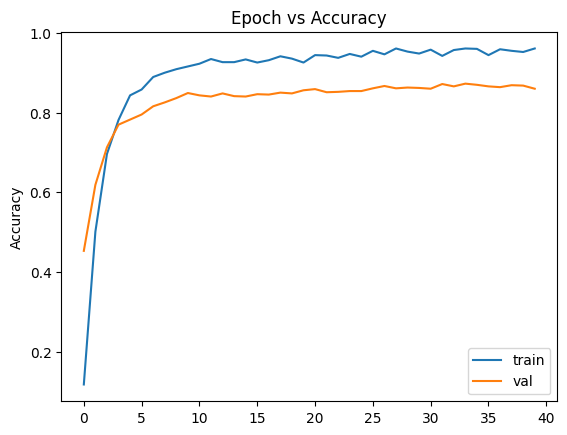

In [106]:
plot_graph(num_epochs, train_acc, val_acc, "Epoch vs Accuracy")

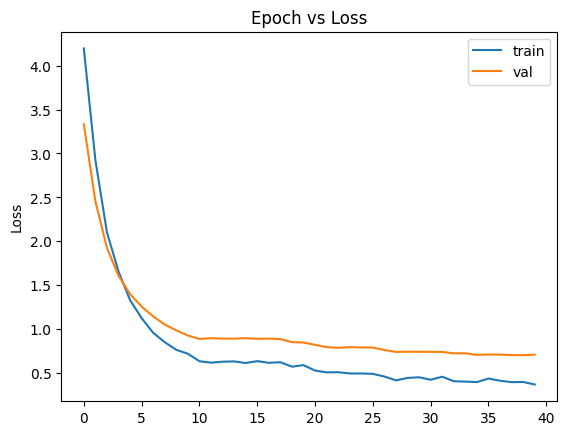

In [105]:
plot_graph(num_epochs, train_loss, val_loss, "Epoch vs Loss")

### Visualising loaded model on validation set

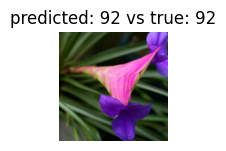

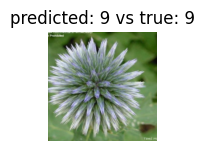

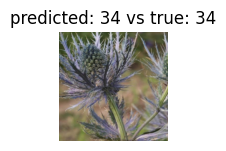

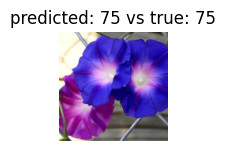

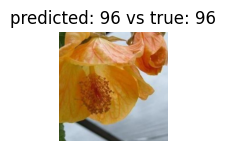

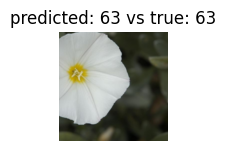

In [108]:
visualize_model(model_conv)

### Testing on test set

In [109]:
def test(model):
    was_training = model.training
    model.eval()
    # fig = plt.figure()
    size = len(dataloaders['test'].dataset)
    no_batches = len(dataloaders['test'])
    test_loss, correct = 0, 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            preds = preds.to(device)
            
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)
            if i % 20 == 0:
                print(f'Predicted: {preds[0]} | True: {labels[0]}')
  
    test_loss /= size
    correct = correct.double() / size
    model.train(mode=was_training)
    return test_loss, correct

In [110]:
test_loss, test_acc = test(model_conv)

Predicted: 54 | True: 0
Predicted: 30 | True: 3
Predicted: 4 | True: 4
Predicted: 7 | True: 7
Predicted: 9 | True: 9
Predicted: 11 | True: 11
Predicted: 12 | True: 12
Predicted: 15 | True: 15
Predicted: 65 | True: 16
Predicted: 18 | True: 18
Predicted: 21 | True: 21
Predicted: 22 | True: 22
Predicted: 26 | True: 26
Predicted: 28 | True: 28
Predicted: 29 | True: 29
Predicted: 32 | True: 32
Predicted: 35 | True: 35
Predicted: 36 | True: 36
Predicted: 37 | True: 37
Predicted: 40 | True: 40
Predicted: 40 | True: 40
Predicted: 42 | True: 42
Predicted: 42 | True: 42
Predicted: 44 | True: 44
Predicted: 45 | True: 45
Predicted: 45 | True: 45
Predicted: 46 | True: 46
Predicted: 48 | True: 48
Predicted: 52 | True: 50
Predicted: 50 | True: 50
Predicted: 29 | True: 50
Predicted: 51 | True: 51
Predicted: 52 | True: 52
Predicted: 53 | True: 53
Predicted: 55 | True: 55
Predicted: 56 | True: 56
Predicted: 57 | True: 57
Predicted: 58 | True: 58
Predicted: 59 | True: 59
Predicted: 61 | True: 61
Predicte

In [111]:
print(f"Test Loss: {test_loss}")
print(f"Test Acc: {test_acc}")

Test Loss: 0.760618363104362
Test Acc: 0.8549357619125062
